In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

In [2]:
import pandas as pd
import utils
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from active_learning import get_tracked_lineages_df, get_earliest_dates

%config InlineBackend.figure_format = 'svg'

In [3]:
settings = utils.load_settings(path="../settings_sample.json")
cleaned_data_dir = settings["cleaned_data_dir"]
plots_dir = settings["plots_dir"]
reports_dir = settings["reports_dir"]
features_dir = settings["features_dir"]
start_date = settings["detection_start_date"]
n_days_delta = settings["detection_step"]

In [4]:
long_qs2_short = {
    "margin_sampling": "ms",
    "least_confident": "lc",
    "entropy": "en",
}

In [5]:
df = pd.read_parquet(os.path.join(cleaned_data_dir, "cleaned_dataset.parquet"))
df.drop(columns=["Accession ID", "col_date", "sub_date", 'country'], inplace=True)

In [6]:
detection_files = [x for x in os.listdir(os.path.join(reports_dir, "detection")) if x.endswith('.tsv') and '_detection_dates_' in x]

In [7]:
def get_model_detection_dates(feature:str, query_strategy:str, dump_dir:str, correct_dates:bool=False):
    assert query_strategy in ['least_confident', 'margin_sampling', 'entropy'], f"Invalid query strategy: {query_strategy}"
    assert feature in ['kmer_5', 'kmer_6', 'kmer_7', 'kmer_8', 'fcgr_64', 'fcgr_128', 'murugaiah'], f"Invalid feature: {feature}"

    file_path = os.path.join(dump_dir, "detection", f'{feature}_detection_dates_{query_strategy}.tsv')
    if os.path.exists(file_path):
        model_dates = pd.read_csv(file_path, sep='\t')
        model_dates['model_date'] = pd.to_datetime(model_dates['model_date'])
        if correct_dates:
            model_dates['model_date'] = model_dates['model_date'] + pd.Timedelta(days=n_days_delta)
        model_dates.rename(columns={'model_date': f'{feature}_{long_qs2_short[query_strategy]}'}, inplace=True)
        return model_dates
    else:
        print(f"File not found: {file_path}")

In [8]:
for file in detection_files:
    keys = file.split('_detection_dates_')
    feature, query_strategy = keys[0], keys[1].split('.')[0]
    model_dates = get_model_detection_dates(feature, query_strategy, reports_dir, correct_dates=True)
    if model_dates is not None:
        if 'model_detection_dates_df' not in locals():
            model_detection_dates_df = model_dates
        else:
            model_detection_dates_df = model_detection_dates_df.merge(model_dates, on='lineage', how='outer')

In [9]:
vois_df = get_tracked_lineages_df(df)
designation_dates = vois_df[['lineage', 'who_label', 'count', 'designation_date', 'first_dataset_date']]

In [10]:
merged_df = pd.merge(designation_dates, model_detection_dates_df, on='lineage', how='left')

In [11]:
column_order = [
    'who_label', 'earliest_date', 'designation_date', 'first_dataset_date', 
    'kmer_5_en', 'kmer_5_lc', 'kmer_5_ms', 
    'kmer_6_en', 'kmer_6_lc', 'kmer_6_ms', 
    'kmer_7_en', 'kmer_7_lc', 'kmer_7_ms', 
    'kmer_8_en', 'kmer_8_lc', 'kmer_8_ms', 
    'fcgr_64_en', 'fcgr_64_lc', 'fcgr_64_ms', 
    'fcgr_128_en', 'fcgr_128_lc', 'fcgr_128_ms', 
    'murugaiah_en', 'murugaiah_lc', 'murugaiah_ms'
]

In [12]:
target_cols = [x for x in column_order if 'kmer' in x or 'fcgr' in x or 'murugaiah' in x]

In [13]:
def get_aggegation_dict(kind:str):
    assert kind in ['min', 'max'], f"Invalid kind: {kind}"
    aggregation_dict = {target: kind for target in target_cols}
    aggregation_dict['designation_date'] = kind
    aggregation_dict['first_dataset_date'] = kind
    return aggregation_dict

In [14]:
min_summary_merged_df = merged_df.groupby('who_label').agg(get_aggegation_dict('min')).reset_index()

In [15]:
earliest_dates = get_earliest_dates()

In [16]:
min_summary_merged_df = min_summary_merged_df.merge(earliest_dates, on='who_label', how='left')
min_summary_merged_df = min_summary_merged_df[column_order]

min_summary_merged_df.sort_values('designation_date', inplace=True)

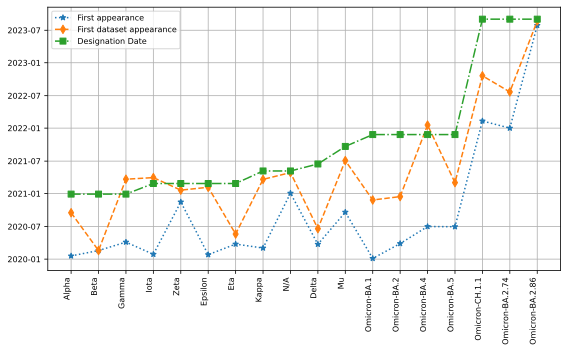

In [17]:
plt.figure(figsize=(8, 5))
cmap = mpl.colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(min_summary_merged_df.columns[1:])))

plt.plot(min_summary_merged_df['who_label'], min_summary_merged_df['earliest_date'], marker='*', linestyle=':', label='First appearance')
plt.plot(min_summary_merged_df['who_label'], min_summary_merged_df['first_dataset_date'], marker='d', linestyle='--', label='First dataset appearance')
plt.plot(min_summary_merged_df['who_label'], min_summary_merged_df['designation_date'], marker='s', linestyle='-.', label='Designation Date')

# plt.ylabel('Date', fontsize=8)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.legend(loc='best', fontsize=8)
plt.tight_layout()
plt.grid(True)
plt.savefig(os.path.join(plots_dir, 'variants-dates.pdf'), dpi=600, format='pdf', bbox_inches='tight')


In [18]:
# plt.figure(figsize=(11, 6))
# cmap = mpl.colormaps.get_cmap('viridis')
# colors = cmap(np.linspace(0, 1, len(min_summary_merged_df.columns[1:])))

# plt.plot(min_summary_merged_df['who_label'], min_summary_merged_df['designation_date'], marker='s', linestyle='-.', label='Designation Date')

# for i, col in enumerate(model_detection_dates_df.columns[1:]):
#     plt.plot(min_summary_merged_df['who_label'], min_summary_merged_df[col], marker='o', linestyle='-', label=col, color=colors[i])

# # plt.xlabel('WHO Label')
# plt.ylabel('Date')
# # plt.title('Earliest Model date VS Designation Date for Each WHO Label')
# plt.xticks(rotation=40)

# plt.legend(bbox_to_anchor = (1.34, 0.5), loc='center right')
# plt.tight_layout()

# plt.savefig(os.path.join(plots_dir, 'earliest_model_date_vs_designation_date.png'), dpi=600)

In [19]:
uncertainty_measures = ['en', 'lc', 'ms']
measure_to_name = {
    'lc': 'Least Confident',
    'en': 'Entropy',
    'ms': 'Margin Sampling'
}

features = ['kmer_5', 'kmer_6', 'kmer_7', 'kmer_8', 'fcgr_64', 'fcgr_128', 'murugaiah']

def get_label(col:str):
    if 'kmer_5' in col: return '5-mers'
    if 'kmer_6' in col: return '6-mers'
    if 'kmer_7' in col: return '7-mers'
    if 'kmer_8' in col: return '8-mers'
    if 'fcgr_64' in col: return 'FCGR-64'
    if 'fcgr_128' in col: return 'FCGR-128'
    if 'murugaiah' in col: return 'Murugaiah'

In [20]:
def plot_all_simulation_results(results_df, save=True):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    for i, measure in enumerate(uncertainty_measures):
        ax = axs[i]
        ax.plot(results_df['who_label'], results_df['designation_date'], marker='s', linestyle='-.', label='Designation Date')
        ax.plot(results_df['who_label'], results_df['first_dataset_date'], marker='d', linestyle='--', label='Dataset Appearance')
        for col in results_df.columns[1:]:
            if measure in col:
                ax.plot(results_df['who_label'], results_df[col], marker='o', linestyle='-', label=get_label(col))
        
        # ax.set_xlabel('WHO Label')
        ax.set_title(f'{measure_to_name[measure]} dates')
        ax.tick_params(axis='x', rotation=75)

    # axs[0].set_ylabel('Date')
    # fig.suptitle('Detection Dates by WHO Label and Uncertainty Measure')
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1), title='Features')
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    if save:
        fig.savefig(os.path.join(plots_dir, 'models_vs_designation_date.png'), dpi=600)


def plot_simulation_results(results_df, measure, save=True):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(11, 9))
    axes = axes.flatten()
    handles, labels = [], []

    for i, ax in enumerate(axes):
        ax = axes[i]

        if i >= len(features):
            ax.legend(handles, labels, loc='best', title='Legend', fontsize="8")
            break
        
        col = features[i] + f'_{measure}'
        ax.plot(results_df['who_label'], results_df['earliest_date'], marker='*', linestyle=':', label='First appearance')
        ax.plot(results_df['who_label'], results_df['first_dataset_date'], marker='d', linestyle='--', label='First appearance in dataset')
        ax.plot(results_df['who_label'], results_df['designation_date'], marker='s', linestyle='-.', label='Official designation date')
        ax.plot(results_df['who_label'], results_df[col], marker='o', linestyle='-', label='Feature')
        ax.grid(True)
        ax.set_title(get_label(col), fontsize=9)
        ax.xaxis.set_ticks(results_df['who_label'])
        ax.set_xticklabels(results_df['who_label'], rotation=50, ha='right', fontsize=8)
        ax.tick_params(axis='y', labelsize=8)
        ax.legend().set_visible(False)

        if i == len(features) - 1:
            for handle, label in zip(*ax.get_legend_handles_labels()):
                handles.append(handle)
                labels.append(label)

    for i in range(len(features), len(axes)):
        # fig.delaxes(axes[i])
        axes[i].axis('off')
    
    # fig.suptitle(f'Simulation with the {measure_to_name[measure]} uncertainty measure')
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    
    if save:
        fig.savefig(os.path.join(plots_dir, f'models_vs_designation_date_{measure}.pdf'), format="pdf", dpi=600, bbox_inches='tight')

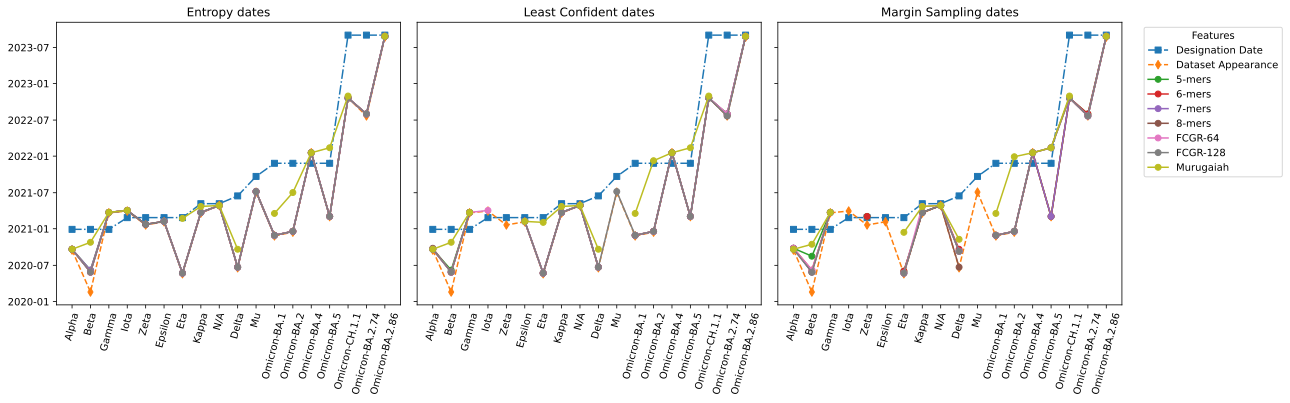

In [52]:
plot_all_simulation_results(min_summary_merged_df, save=True)

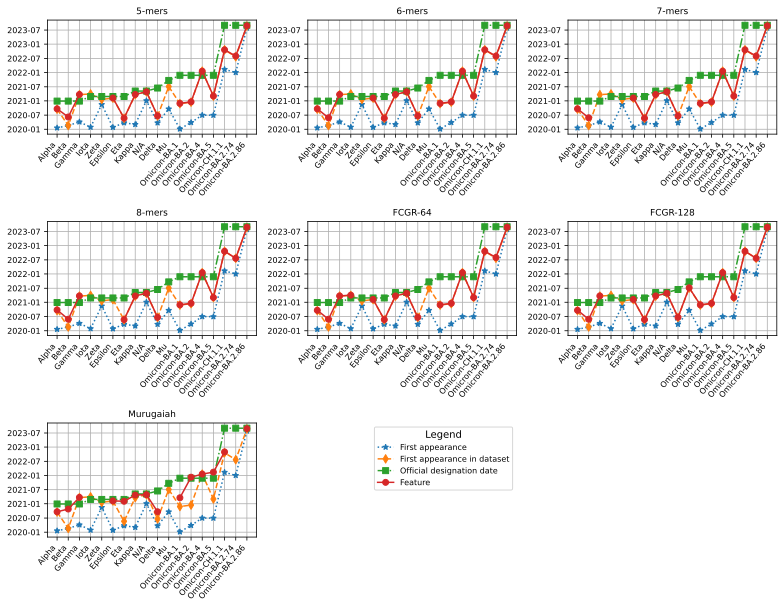

In [22]:
plot_simulation_results(min_summary_merged_df, 'lc', save=True)

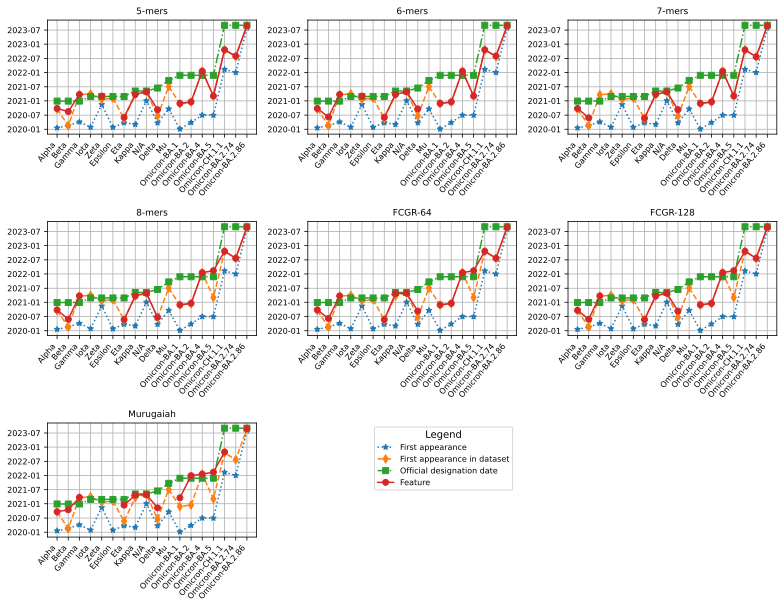

In [23]:
plot_simulation_results(min_summary_merged_df, 'ms', save=True)

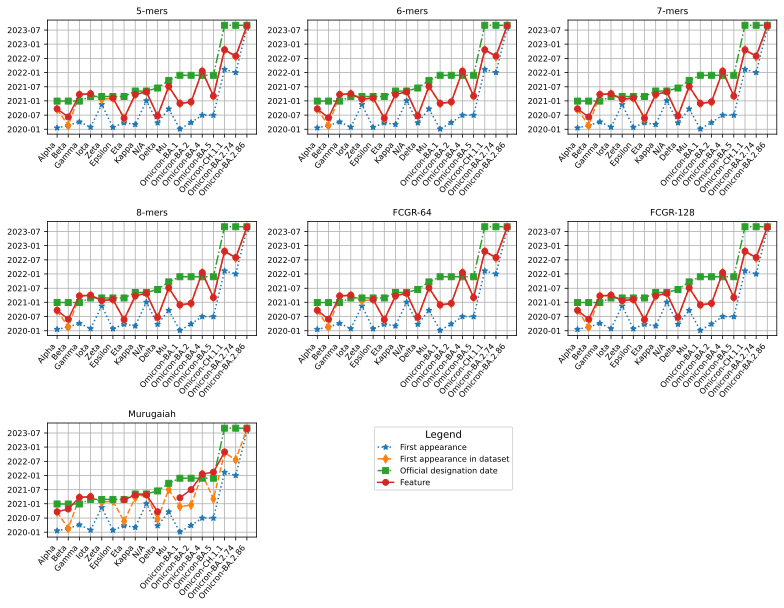

In [24]:
plot_simulation_results(min_summary_merged_df, 'en', save=True)

In [25]:
# # Plotting
# plt.figure(figsize=(11, 6))

# plt.plot(merged_df['lineage'], merged_df['designation_date'], linestyle='-', label='Designation Date', linewidth=2)

# for col in model_detection_dates_df.columns[1:]:
#     plt.plot(merged_df['lineage'], merged_df[col], linestyle='-', label=col)

# plt.xlabel('Lineage')
# plt.ylabel('Date')
# plt.title('Model date VS Designation Date for Each Lineage')
# plt.xticks(rotation=90)

# plt.legend(bbox_to_anchor = (1.34, 0.5), loc='center right')
# plt.tight_layout()

# plt.savefig(os.path.join(plots_dir, 'model_date_vs_designation_date.png'), dpi=300)

In [26]:
min_summary_merged_df.to_excel(os.path.join(reports_dir, 'summary_model_detection_dates_vs_designation_dates.xlsx'), index=False)

In [27]:
merged_df.to_excel(os.path.join(reports_dir, 'model_detection_dates_vs_designation_dates.xlsx'), index=False)

# Detection Lead Time analysis

In [28]:
detection_lt = {}
detection_lt['who_label'] = min_summary_merged_df['who_label']

for target in target_cols:
    detection_lt[target] = ( min_summary_merged_df['designation_date'] - min_summary_merged_df[target]).dt.days

detection_lt_df = pd.DataFrame(detection_lt)

In [29]:
# Counts negatives per column
(detection_lt_df.drop(['who_label'], axis=1) < 0).sum()
# (detection_lt_df.filter(like="en") < 0)

kmer_5_en       3
kmer_5_lc       2
kmer_5_ms       3
kmer_6_en       3
kmer_6_lc       2
kmer_6_ms       3
kmer_7_en       3
kmer_7_lc       1
kmer_7_ms       1
kmer_8_en       3
kmer_8_lc       2
kmer_8_ms       3
fcgr_64_en      3
fcgr_64_lc      3
fcgr_64_ms      3
fcgr_128_en     3
fcgr_128_lc     2
fcgr_128_ms     3
murugaiah_en    4
murugaiah_lc    4
murugaiah_ms    4
dtype: int64

In [30]:
# Counts NaNs (undetected) per column
detection_lt_df.drop(['who_label'], axis=1).isna().sum()

kmer_5_en       1
kmer_5_lc       3
kmer_5_ms       3
kmer_6_en       0
kmer_6_lc       3
kmer_6_ms       3
kmer_7_en       0
kmer_7_lc       4
kmer_7_ms       5
kmer_8_en       0
kmer_8_lc       4
kmer_8_ms       4
fcgr_64_en      1
fcgr_64_lc      2
fcgr_64_ms      4
fcgr_128_en     0
fcgr_128_lc     2
fcgr_128_ms     4
murugaiah_en    4
murugaiah_lc    4
murugaiah_ms    5
dtype: int64

In [31]:
detection_lt_df.filter(like="en").mean().mean(), detection_lt_df.filter(like="lc").mean().mean(), detection_lt_df.filter(like="ms").mean().mean()

(137.25897025476854, 157.16666666666669, 148.7004186289901)

In [32]:
detection_lt_df.filter(like="ms").isna().sum().mean()

4.0

## Statistic tests for sign check

In [34]:
tests_results_sign = {"stat": [], "p_value": []}

for target in target_cols:
    stat, p_value = utils.sign_test(detection_lt_df, target)
    tests_results_sign["stat"].append(stat)
    tests_results_sign["p_value"].append(p_value)

tests_results_df_sign = pd.DataFrame(tests_results_sign, index=target_cols)
tests_results_df_sign[tests_results_df_sign.index.str.contains('ms')][['p_value']]

,p_value
kmer_5_ms,0.017578
kmer_6_ms,0.017578
kmer_7_ms,0.001709
kmer_8_ms,0.028687
fcgr_64_ms,0.028687
fcgr_128_ms,0.028687
murugaiah_ms,0.133423


In [35]:
tests_results_wil = {"stat": [], "p_value": []}

for target in target_cols:
    stat, p_value = utils.wilcoxon_test(detection_lt_df, target)
    tests_results_wil["stat"].append(stat)
    tests_results_wil["p_value"].append(p_value)

tests_results_df_wil = pd.DataFrame(tests_results_wil, index=target_cols)
tests_results_df_wil[tests_results_df_wil.index.str.contains('ms')][['p_value']]

,p_value
kmer_5_ms,0.002686
kmer_6_ms,0.002686
kmer_7_ms,0.000854
kmer_8_ms,0.008301
fcgr_64_ms,0.008301
fcgr_128_ms,0.008301
murugaiah_ms,0.095459


## Histograms

### Overall DLT histogram

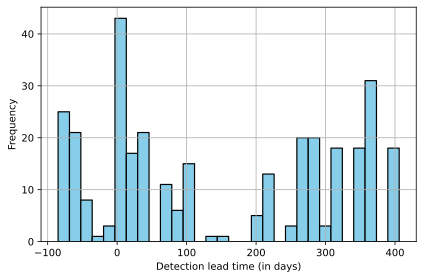

In [36]:
all_dlt_np = detection_lt_df.drop(columns=['who_label']).to_numpy().flatten()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(all_dlt_np, bins=30, color='skyblue', edgecolor='black', linewidth=1.2)
ax.set_xlabel('Detection lead time (in days)')
ax.set_ylabel('Frequency')
ax.grid(True)
# ax.set_title('Histogram of Lag in days between Designation Date and Model Detection Date')
fig.tight_layout()
fig.savefig(os.path.join(plots_dir, 'dlt_days_hist.pdf'), dpi=500, format='pdf', bbox_inches='tight')

### DLT histogram per Uncertainty Measure

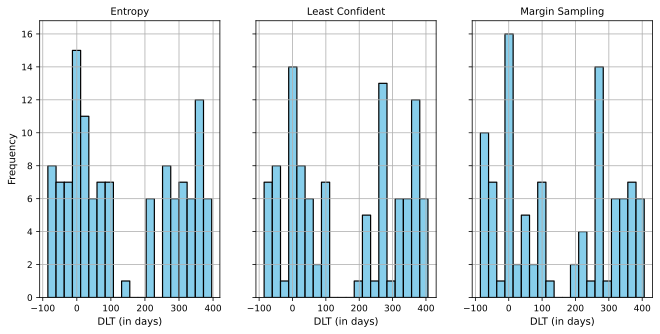

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(11, 5), sharey=True)
for i, ax in enumerate(axes):
    ucm = uncertainty_measures[i]
    dlt_df = detection_lt_df.filter(like=ucm)
    dlt_np = dlt_df.to_numpy().flatten()
    ax.hist(dlt_np, bins=20, color='skyblue', edgecolor='black', linewidth=1.2, density=False)
    ax.set_title(f'{measure_to_name[ucm]}', fontsize=10)
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.grid(True)
    ax.set_xlabel('DLT (in days)')
    if i == 0: ax.set_ylabel('Frequency')

fig.savefig(os.path.join(plots_dir, 'dlt_hist_per_ucm.pdf'), bbox_inches='tight', dpi=500, format='pdf')

### Average DLT by Uncertainty Measure and Feature

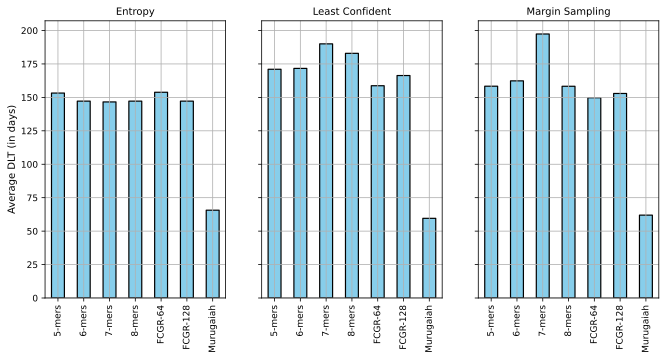

In [38]:
avg_dlt_features = pd.DataFrame(detection_lt_df.drop(columns=['who_label']).mean(), columns=['mean'])

fig, axes = plt.subplots(1, 3, figsize=(11, 5), sharey=True)
for i, ax in enumerate(axes):
    ucm = uncertainty_measures[i]
    avg_df = avg_dlt_features[avg_dlt_features.index.str.contains(ucm)]
    avg_df.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black', linewidth=1.2)
    ax.set_xticklabels([get_label(x) for x in avg_df.index], rotation=90)
    ax.legend().set_visible(False)
    ax.set_title(f'{measure_to_name[ucm]}', fontsize=10)
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.grid(True)
    if i == 0: ax.set_ylabel('Average DLT (in days)')

fig.savefig(os.path.join(plots_dir, 'avg_dlt_hist_per_ucm_feature.pdf'), bbox_inches='tight', dpi=500, format='pdf')

### Average DLT by Uncertainty Measure and Variant

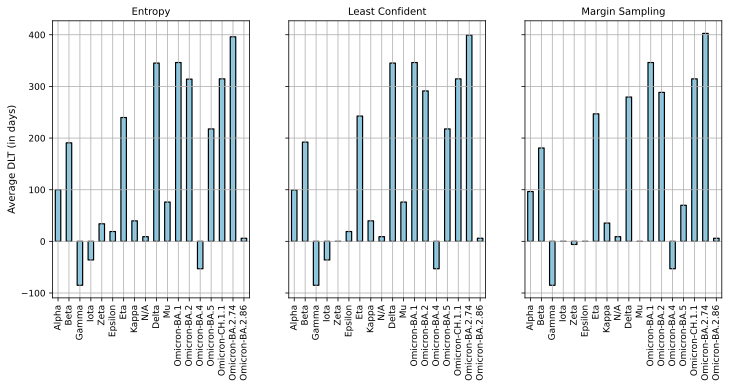

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
for i, ax in enumerate(axes):
    ucm = uncertainty_measures[i]
    ucm_variants_df = detection_lt_df.filter(like=ucm).T
    ucm_variants_df.columns = detection_lt_df['who_label'].values
    ucm_variants_df.mean().plot(kind='bar', ax=ax, color='skyblue', edgecolor='black', linewidth=1.2)
    ax.set_title(f'{measure_to_name[ucm]}', fontsize=10)
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.grid(True)
    if i == 0: ax.set_ylabel('Average DLT (in days)')

fig.savefig(os.path.join(plots_dir, 'avg_dlt_hist_per_ucm_variant.pdf'), dpi=500, format='pdf', bbox_inches='tight')

In [40]:
ucm_variants_df = detection_lt_df.filter(like='ms').T
ucm_variants_df.columns = detection_lt_df['who_label'].values
ucm_variants_df.mean()

Alpha               96.428571
Beta               180.714286
Gamma              -85.000000
Iota                      NaN
Zeta                -6.000000
Epsilon                   NaN
Eta                246.857143
Kappa               35.428571
N/A                  9.000000
Delta              279.428571
Mu                        NaN
Omicron-BA.1       346.285714
Omicron-BA.2       288.428571
Omicron-BA.4       -53.000000
Omicron-BA.5        69.857143
Omicron-CH.1.1     314.571429
Omicron-BA.2.74    402.666667
Omicron-BA.2.86      6.000000
dtype: float64

# Time to detection analysis

In [41]:
time_to_detection = {}
time_to_detection['who_label'] = min_summary_merged_df['who_label']

for target in target_cols:
    time_to_detection[target] = (min_summary_merged_df[target] - min_summary_merged_df['first_dataset_date']).dt.days

time_to_detection_df = pd.DataFrame(time_to_detection)

### Overall TTD histogram

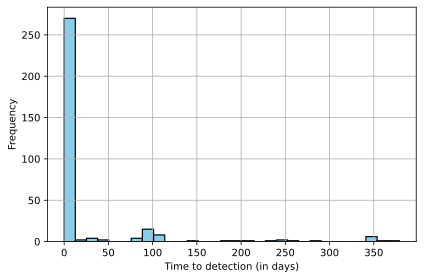

In [42]:
all_ttd_np = time_to_detection_df.drop(columns=['who_label']).to_numpy().flatten()


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(all_ttd_np, bins=30, color='skyblue', edgecolor='black', linewidth=1.2)
ax.set_xlabel('Time to detection (in days)')
ax.set_ylabel('Frequency')
ax.grid(True)
# ax.set_title('Histogram of Lag in days between Designation Date and Model Detection Date')
fig.tight_layout()
fig.savefig(os.path.join(plots_dir, 'ttd_days_hist.pdf'), dpi=500, format='pdf')

In [43]:
(n, bins, patches) = ax.hist(all_ttd_np, bins=30, color='skyblue', edgecolor='black', linewidth=1.2)

In [44]:
len(all_ttd_np), len(time_to_detection_df.columns)

(378, 22)

In [45]:
18 * 21

378

In [46]:
time_to_detection_df.isna().sum().sum()

56

### TTD histogram by Uncertainty Measure

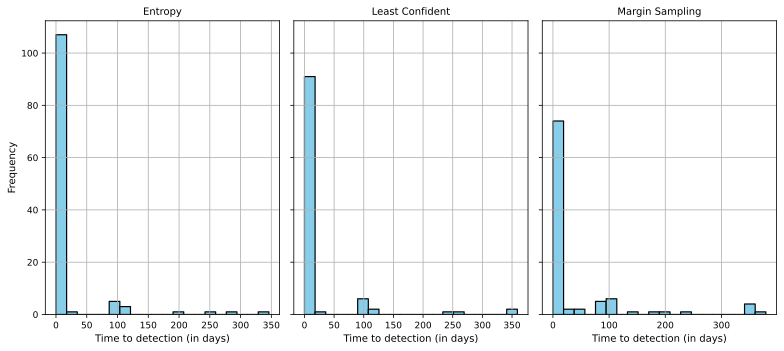

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(11, 5), sharey=True)
for i, ax in enumerate(axes):
    ucm = uncertainty_measures[i]
    dlt_df = time_to_detection_df.filter(like=ucm)
    dlt_np = dlt_df.to_numpy().flatten()
    ax.hist(dlt_np, bins=20, color='skyblue', edgecolor='black', linewidth=1.2, density=False)
    ax.set_title(f'{measure_to_name[ucm]}', fontsize=10)
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.grid(True)
    ax.set_xlabel('Time to detection (in days)')
    if i == 0: ax.set_ylabel('Frequency')

fig.tight_layout()
fig.savefig(os.path.join(plots_dir, 'ttd_hist_per_ucm.pdf'), dpi=500, format='pdf', bbox_inches='tight')

### Average TTD by Uncertainty Measure and Feature

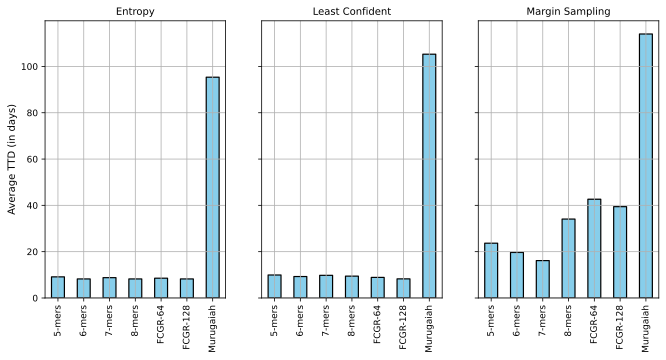

In [48]:
avg_ttd_features = pd.DataFrame(time_to_detection_df.drop(columns=['who_label']).mean(), columns=['mean'])

fig, axes = plt.subplots(1, 3, figsize=(11, 5), sharey=True)
for i, ax in enumerate(axes):
    ucm = uncertainty_measures[i]
    avg_df = avg_ttd_features[avg_ttd_features.index.str.contains(ucm)]
    avg_df.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black', linewidth=1.2)
    ax.set_xticklabels([get_label(x) for x in avg_df.index], rotation=90)
    ax.legend().set_visible(False)
    ax.set_title(f'{measure_to_name[ucm]}', fontsize=10)
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.grid(True)
    if i == 0: ax.set_ylabel('Average TTD (in days)')

fig.savefig(os.path.join(plots_dir, 'avg_ttd_hist_per_ucm_feature.pdf'), dpi=500, format='pdf')

### Average TTD by Uncertainty Measure and Variant

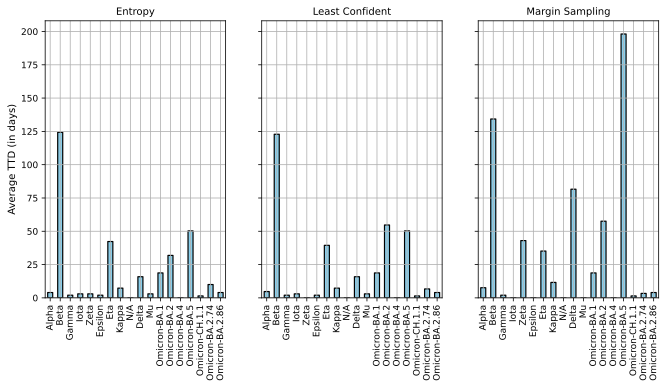

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(11, 5), sharey=True)
for i, ax in enumerate(axes):
    ucm = uncertainty_measures[i]
    ucm_variants_df = time_to_detection_df.filter(like=ucm).T
    ucm_variants_df.columns = time_to_detection_df['who_label'].values
    ucm_variants_df.mean().plot(kind='bar', ax=ax, color='skyblue', edgecolor='black', linewidth=1.2)
    ax.set_title(f'{measure_to_name[ucm]}', fontsize=10)
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.grid(True)
    if i == 0: ax.set_ylabel('Average TTD (in days)')

fig.savefig(os.path.join(plots_dir, 'avg_ttd_hist_per_ucm_variant.pdf'), dpi=500, format='pdf')

## Statistic tests for sign check

In [50]:
tests_results = {"stat": [], "p_value": []}

for target in target_cols:
    stat, p_value = sign_test(time_to_detection_df, target, mu0=15, alternative='less')
    tests_results["stat"].append(stat)
    tests_results["p_value"].append(p_value)

tests_results_df = pd.DataFrame(tests_results, index=target_cols)
tests_results_df[['p_value']]

,p_value
kmer_5_en,0.000137
kmer_5_lc,0.000488
kmer_5_ms,0.017578
kmer_6_en,0.000072
kmer_6_lc,0.000488
kmer_6_ms,0.017578
kmer_7_en,0.000072
kmer_7_lc,0.000916
kmer_7_ms,0.011230
kmer_8_en,0.000072


In [51]:
tests_results_wil = {"stat": [], "p_value": []}

for target in target_cols:
    stat, p_value = wilcoxon_test(time_to_detection_df, target, mu0=15, alternative='less')
    tests_results_wil["stat"].append(stat)
    tests_results_wil["p_value"].append(p_value)

tests_results_df_wil = pd.DataFrame(tests_results_wil, index=target_cols)
tests_results_df_wil[['p_value']]

,p_value
kmer_5_en,0.001579
kmer_5_lc,0.004181
kmer_5_ms,0.165131
kmer_6_en,0.000965
kmer_6_lc,0.004181
kmer_6_ms,0.165131
kmer_7_en,0.000965
kmer_7_lc,0.006714
kmer_7_ms,0.083862
kmer_8_en,0.000965
